# Airbnb
### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

### Q1. Does Airbnb have seasonality to their availability?

In [5]:
df = pd.read_csv('airbnb_calendar.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2702460 entries, 0 to 2702459
Data columns (total 5 columns):
Unnamed: 0     int64
listing_id     int64
date           object
City           object
available_t    int64
dtypes: int64(3), object(2)
memory usage: 103.1+ MB


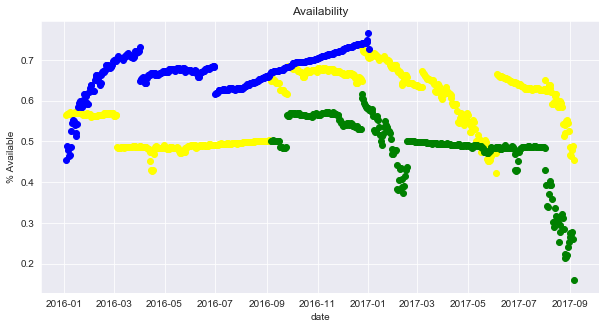

In [63]:
plt.figure(figsize=(10,5))
plt.plot_date(df['date'].unique(), df.groupby(['date']).mean()['available_t'], color='yellow')
plt.plot_date(df[df['City']=='Boston']['date'].unique(), df[df['City']=='Boston'].groupby(['date']).mean()['available_t'], color='green')
plt.plot_date(df[df['City']=='Seattle']['date'].unique(), df[df['City']=='Seattle'].groupby(['date']).mean()['available_t'], color='blue')
plt.title('Availability')
plt.ylabel('% Available')
plt.xlabel('date')
plt.show();

Although some seasonality appears to exist, we may want to categorize the listings a little for better insight

In [74]:
dfl = pd.read_csv('airbnb_listings.csv')

In [71]:
dfl.groupby(['property_type', 'room_type']).count()['id']

property_type    room_type      
Apartment        Entire home/apt    3192
                 Private room       1015
                 Shared room         113
Bed & Breakfast  Entire home/apt       5
                 Private room         71
                 Shared room           2
Boat             Entire home/apt      14
                 Private room          6
Bungalow         Entire home/apt      12
                 Private room          1
Cabin            Entire home/apt      16
                 Private room          5
Camper/RV        Entire home/apt      10
                 Private room          3
                 Shared room           1
Chalet           Entire home/apt       1
                 Private room          1
Condominium      Entire home/apt     222
                 Private room         97
                 Shared room           3
Dorm             Private room          2
                 Shared room           2
Entire Floor     Entire home/apt       2
                 Private

For the purposes of this investigation, we will focus on completely stationary rentals (no RVs, tents, etc)

In [90]:
dfs = dfl[dfl['property_type'].isin(['Apartment', 'Bed & Breakfast','Bungalow','Cabin','Chalet','Condominium','Dorm','Entire Floor','Guesthouse','House','Loft','Townhouse','Treehouse','Villa'])].copy()
dfs['beds'].fillna(1, inplace=True)
dfs['bathrooms'].fillna(1, inplace=True)
dfs['security_deposit'].fillna(0, inplace=True)
dfs['cleaning_fee'].fillna(0, inplace=True)
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7320 entries, 0 to 7402
Data columns (total 36 columns):
Unnamed: 0                          7320 non-null int64
id                                  7320 non-null int64
host_response_rate                  6342 non-null object
host_acceptance_rate                6097 non-null object
host_is_superhost                   7318 non-null object
host_listings_count                 7318 non-null float64
neighbourhood_cleansed              7320 non-null object
latitude                            7320 non-null float64
longitude                           7320 non-null float64
property_type                       7320 non-null object
room_type                           7320 non-null object
accommodates                        7320 non-null int64
bathrooms                           7320 non-null float64
beds                                7320 non-null float64
bed_type                            7320 non-null object
price                               

In [91]:
#Next steps: Inner join to calendar to ruin availability by room type and/or property type